<a href="https://colab.research.google.com/github/Utkarsh-cartman/Advanced-regression/blob/main/Sentiment_Based_Product_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Based Product Recommendation System


## Problem Statement

Suppose you are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

 As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#--- Import libraries
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

import numpy as np
import pandas as pd
from pandas import DataFrame

import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import calendar

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline


import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

## Read and Load Dataset

In [ ]:
# reading the data
# the data sets are in the same directory where the code present, so no need to specify the path
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sample30.csv")
df.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


## Data analyses


In [ ]:
df.shape

(30000, 15)

In [ ]:
#data overivew
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

### Fixing missing data

In [ ]:
#Null precentage
print("Missing values by percentage :")
null_info = df.isna().sum() / len(df) * 100
null_info.sort_values(ascending = False).head(50).round(4)

Missing values by percentage :


reviews_userProvince    99.4333
reviews_userCity        93.5700
reviews_didPurchase     46.8933
reviews_doRecommend      8.5667
reviews_title            0.6333
manufacturer             0.4700
reviews_username         0.2100
reviews_date             0.1533
user_sentiment           0.0033
id                       0.0000
brand                    0.0000
categories               0.0000
name                     0.0000
reviews_rating           0.0000
reviews_text             0.0000
dtype: float64

In [ ]:
print("Feature          Missing Values")
print(df.isnull().sum())

Feature          Missing Values
id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64


## EDA

In [ ]:
# Drop the columns with less than 20% of values
missing_val_threshold = len(df) * .2
df.dropna(thresh = missing_val_threshold, axis = 1, inplace = True)
print("Percentage of missing values :")
print(df.isna().mean().round(4) * 100)

Percentage of missing values :
id                      0.00
brand                   0.00
categories              0.00
manufacturer            0.47
name                    0.00
reviews_date            0.15
reviews_didPurchase    46.89
reviews_doRecommend     8.57
reviews_rating          0.00
reviews_text            0.00
reviews_title           0.63
reviews_username        0.21
user_sentiment          0.00
dtype: float64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   30000 non-null  object
 1   brand                30000 non-null  object
 2   categories           30000 non-null  object
 3   manufacturer         29859 non-null  object
 4   name                 30000 non-null  object
 5   reviews_date         29954 non-null  object
 6   reviews_didPurchase  15932 non-null  object
 7   reviews_doRecommend  27430 non-null  object
 8   reviews_rating       30000 non-null  int64 
 9   reviews_text         30000 non-null  object
 10  reviews_title        29810 non-null  object
 11  reviews_username     29937 non-null  object
 12  user_sentiment       29999 non-null  object
dtypes: int64(1), object(12)
memory usage: 3.0+ MB


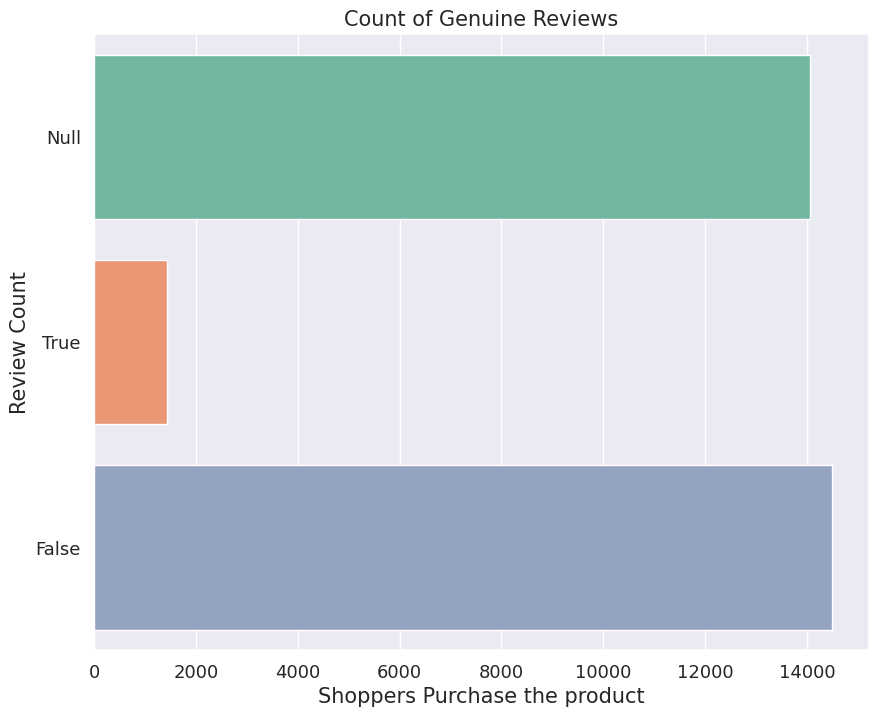

In [ ]:
#on the reviews_didpurchase column, replace null values with "Null"
df['reviews_didPurchase'].fillna('Null', inplace=True)

#checking distribution of reviews_didpurchased

plt.figure(figsize=(10,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(df['reviews_didPurchase'],palette="Set2")
ax.set_xlabel(xlabel="Shoppers Purchase the product", fontsize=15)
ax.set_ylabel(ylabel='Review Count', fontsize=15)
ax.axes.set_title('Count of Genuine Reviews', fontsize=15)
ax.tick_params(labelsize=13)
plt.show()

In [ ]:
df['reviews_didPurchase'].value_counts()

False    14498
Null     14068
True      1434
Name: reviews_didPurchase, dtype: int64

Shoppers who purchase the product and provided the reveiw is just 4% in the dataset. With such low quality data and for sentiment analysis this feature does not add value so we can safely skip it.



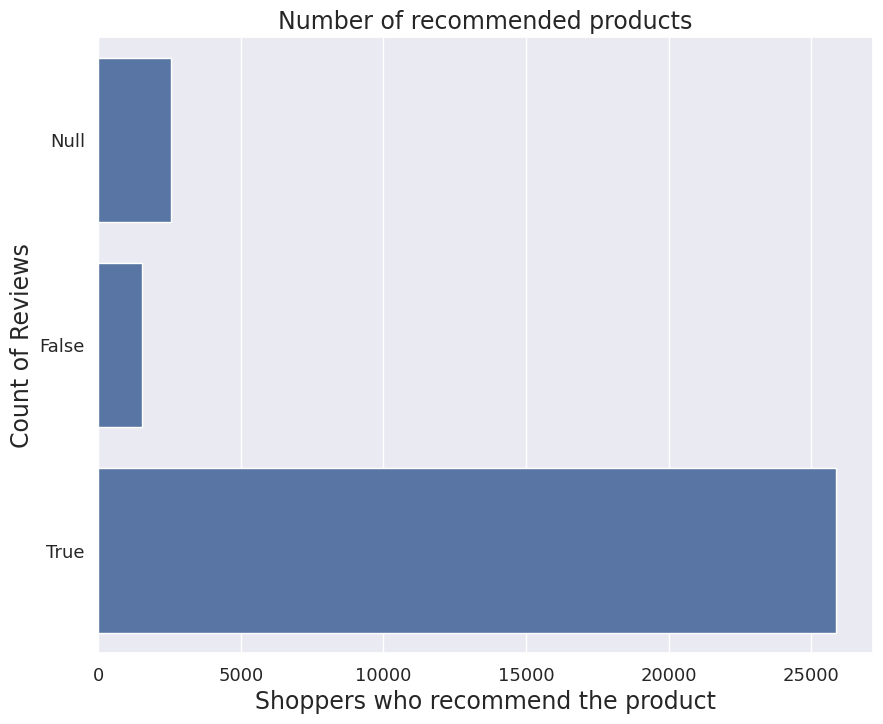

True     25880
Null      2570
False     1550
Name: reviews_doRecommend, dtype: int64

In [ ]:
#on the reviews_doRecommend column, replace null values with "Null"
df['reviews_doRecommend'].fillna('Null', inplace=True)
#checking distribution of reviews_didpurchased

plt.figure(figsize=(10,8))
ax = sns.countplot(df['reviews_doRecommend'])
ax.set_xlabel(xlabel="Shoppers who recommend the product", fontsize=17)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=17)
ax.axes.set_title('Number of recommended products', fontsize=17)
ax.tick_params(labelsize=13)
plt.show()
df['reviews_doRecommend'].value_counts()

DoRecommend column indicates users recommend many products, the quality of data is also good however this column might not value add for our analysis.

In [ ]:
df.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_username', 'user_sentiment'],
      dtype='object')

In [ ]:
#Number of brands , categories in the dataset

print("Brand\n")
print(df['brand'].value_counts())
print("--------------------------\n")
print("Categories\n")
print(df['categories'].value_counts())
print("--------------------------\n")


Brand

Clorox                   10585
Warner Home Video         3325
Disney                    1200
L'oreal Paris             1186
FOX                        887
                         ...  
Pacific Natural Foods        1
Noosa                        1
Southern Enterprises         1
SLOAN VALVE COMPANY          1
Universal Music              1
Name: brand, Length: 214, dtype: int64
--------------------------

Categories

Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Cleaning & Janitorial Supplies,Cleaners & Disinfectants,Cleaning Wipes & Pads,Cleaning Solutions,Housewares,Target Restock,Food & Grocery,Paper Goods,Wipes,All Purpose Cleaners    8545
Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys           

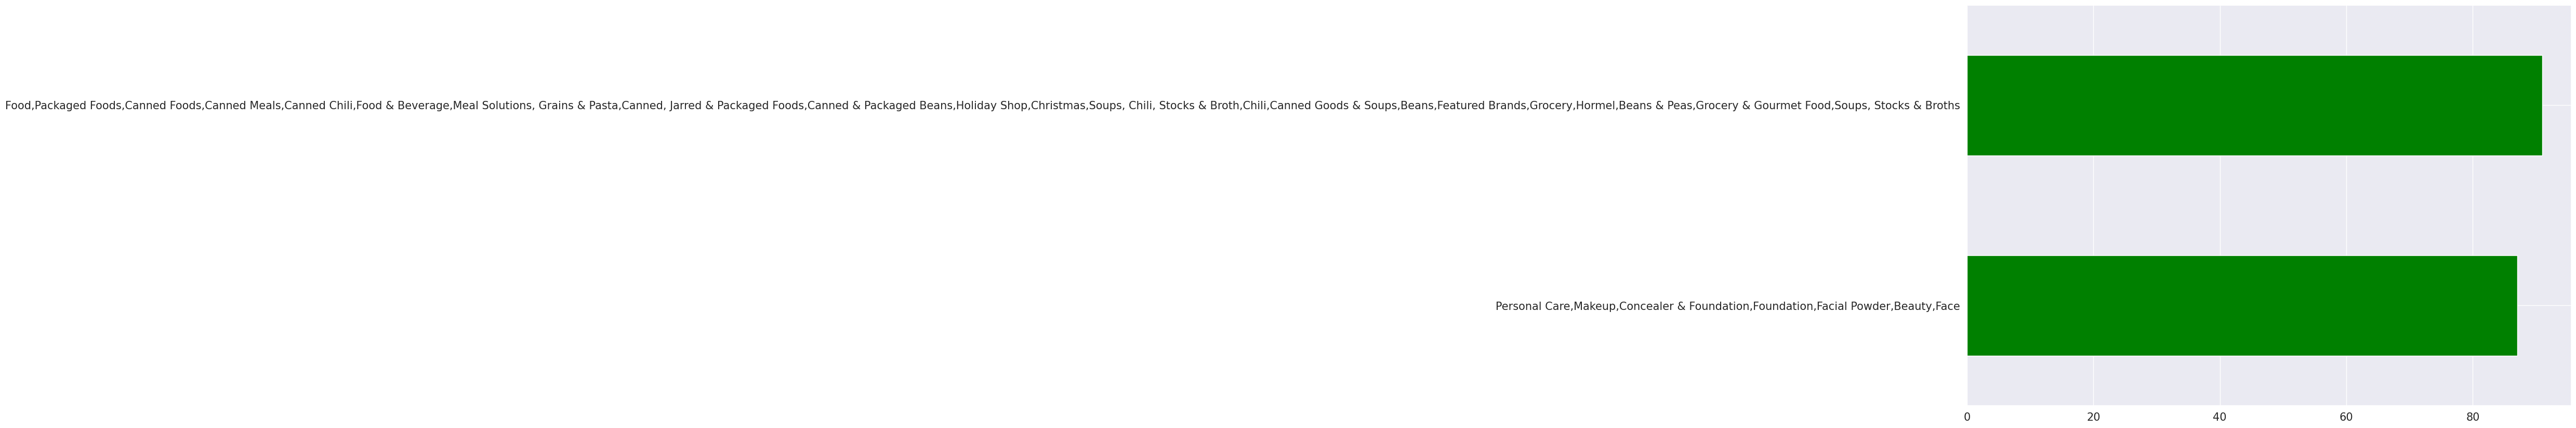

In [ ]:
#Checking Top 2 categories where most people are buying the products

from matplotlib import cm
result = df[(df['reviews_didPurchase'] == True)]
result['categories'].value_counts()[0:2].plot(kind = 'barh', figsize=[15,10], fontsize=15,color='green').invert_yaxis()

*From the data , it shows that Food Items is the most selling category followed by personal care products*

<Axes: >

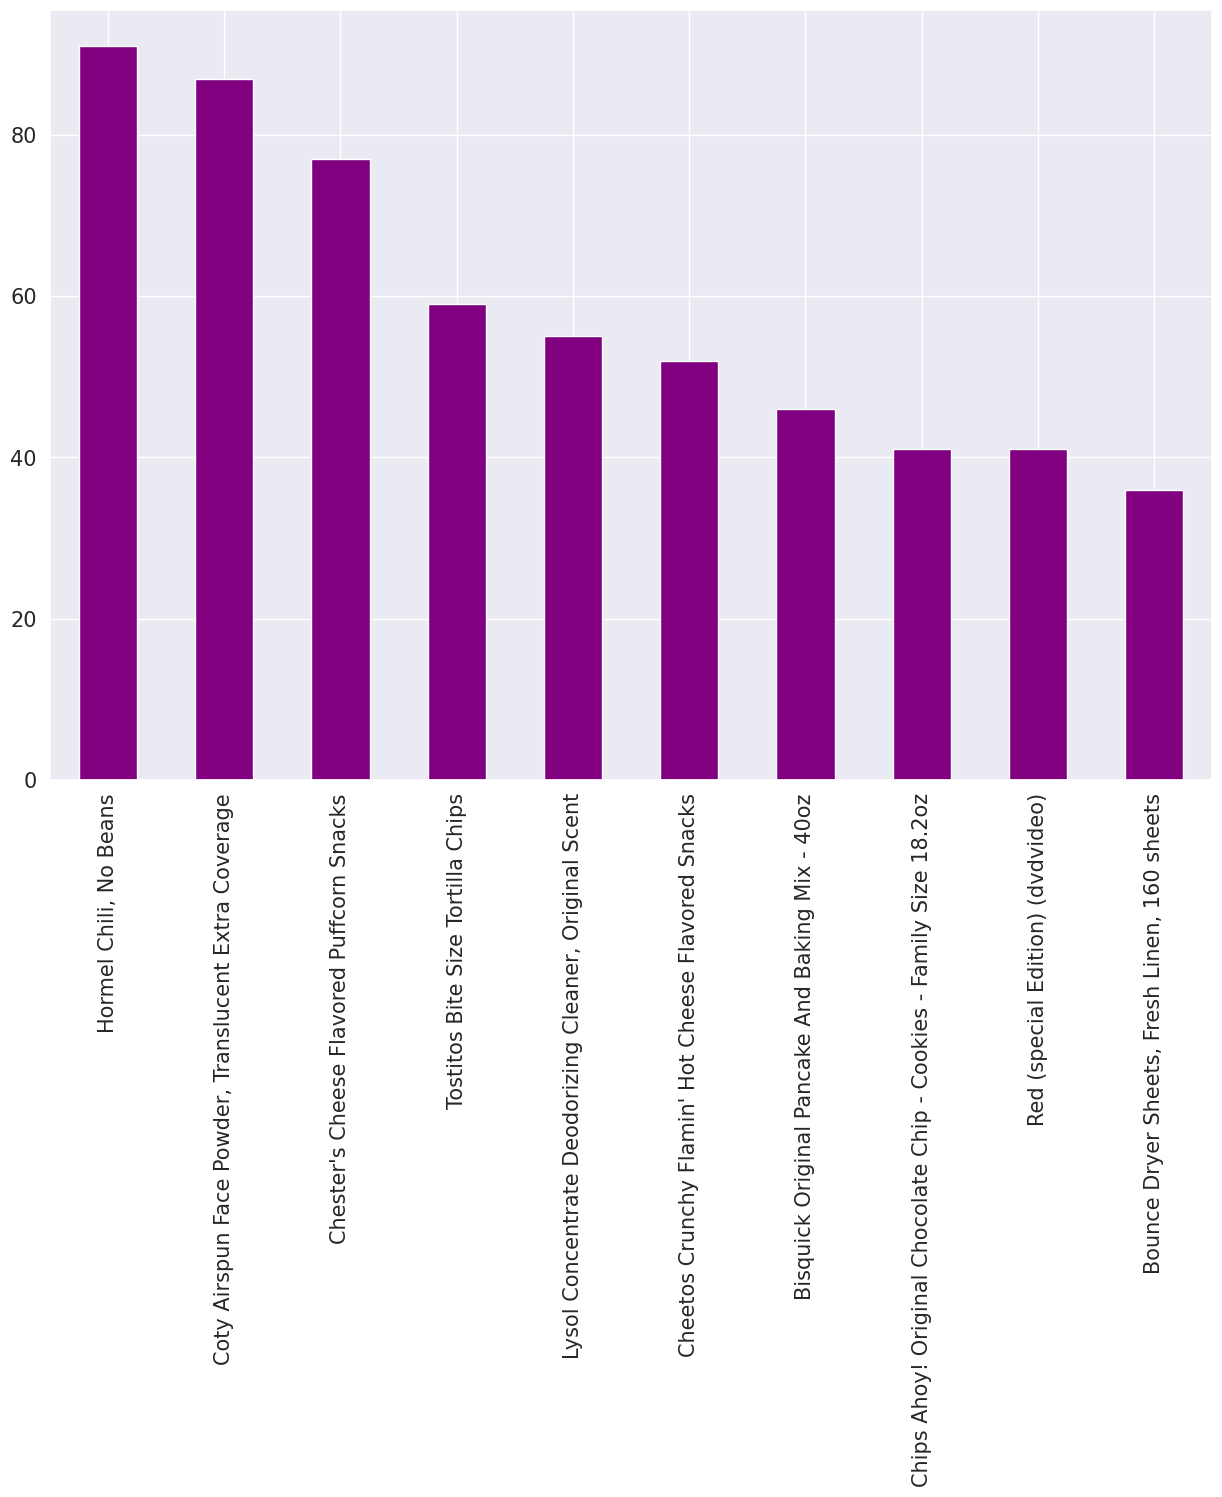

In [ ]:
#Checking top 10 most purchased product

result = df[df['reviews_didPurchase'] == True]
result['name'].value_counts()[0:10].plot(kind = 'bar', figsize=[15,10], fontsize=15,color='purple')

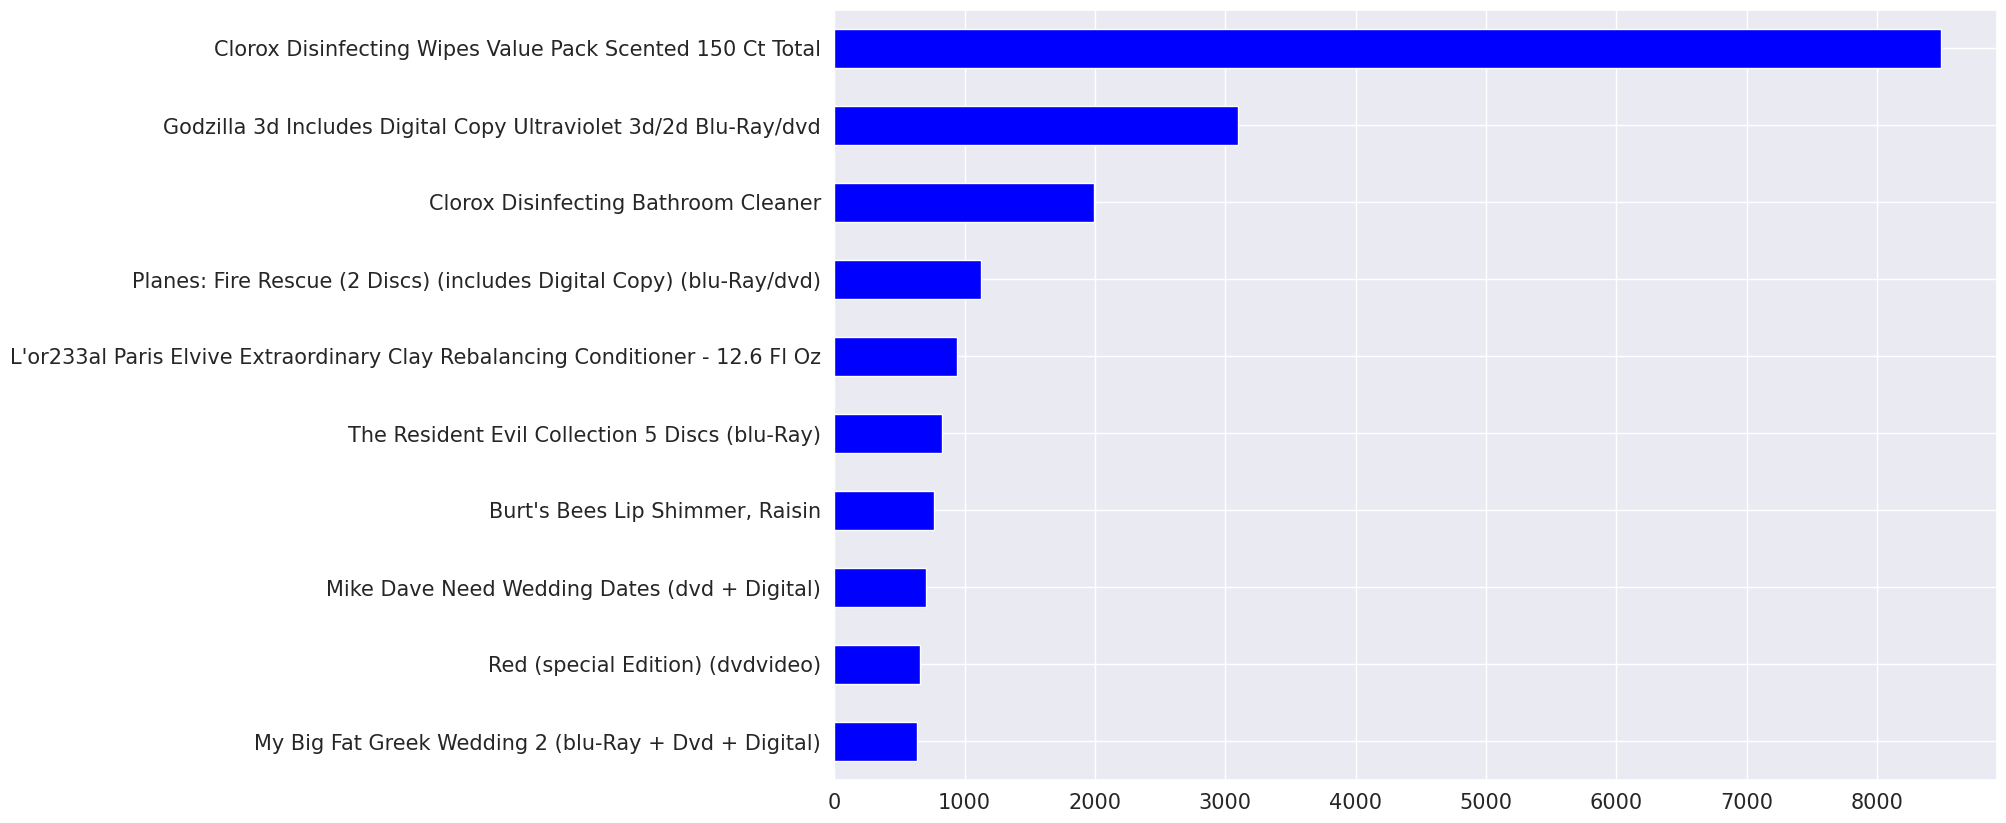

In [ ]:
#Products most recommended

result = df[df['reviews_doRecommend'] == True]
result['name'].value_counts()[0:10].plot(kind = 'barh', figsize=[15,10], fontsize=15,color='blue').invert_yaxis()

<Axes: >

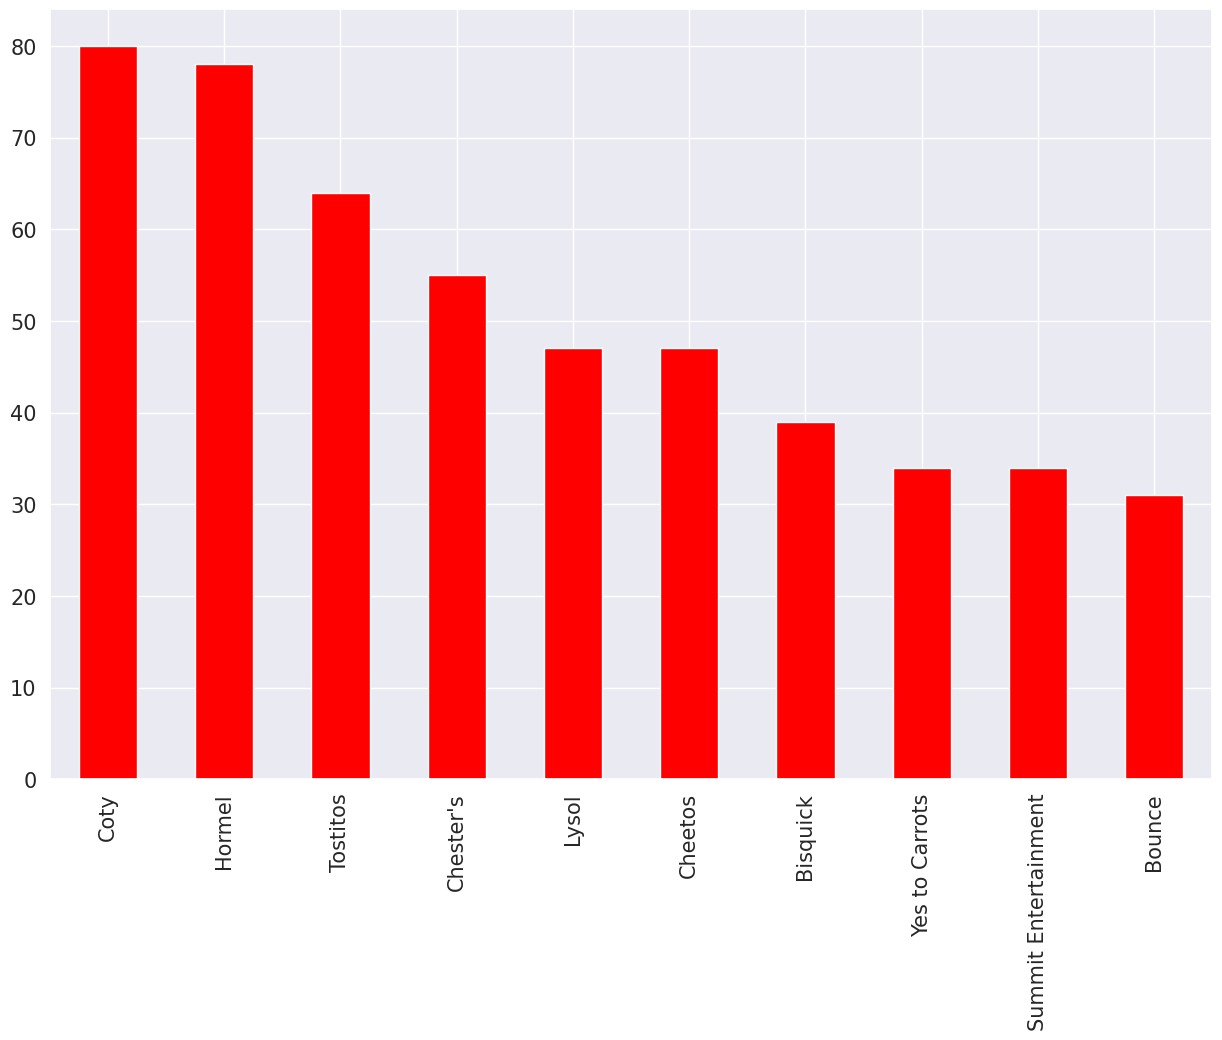

In [ ]:
#Checking top 10 most trusted brands based on the positive review

from matplotlib import cm
result = df[(df['reviews_didPurchase'] == True) & (df.user_sentiment=="Positive")]
result['brand'].value_counts()[0:10].plot(kind = 'bar', figsize=[15,10], fontsize=15,color='Red')

Coty has the high positive rating and is also is the most sought after brand

<Axes: >

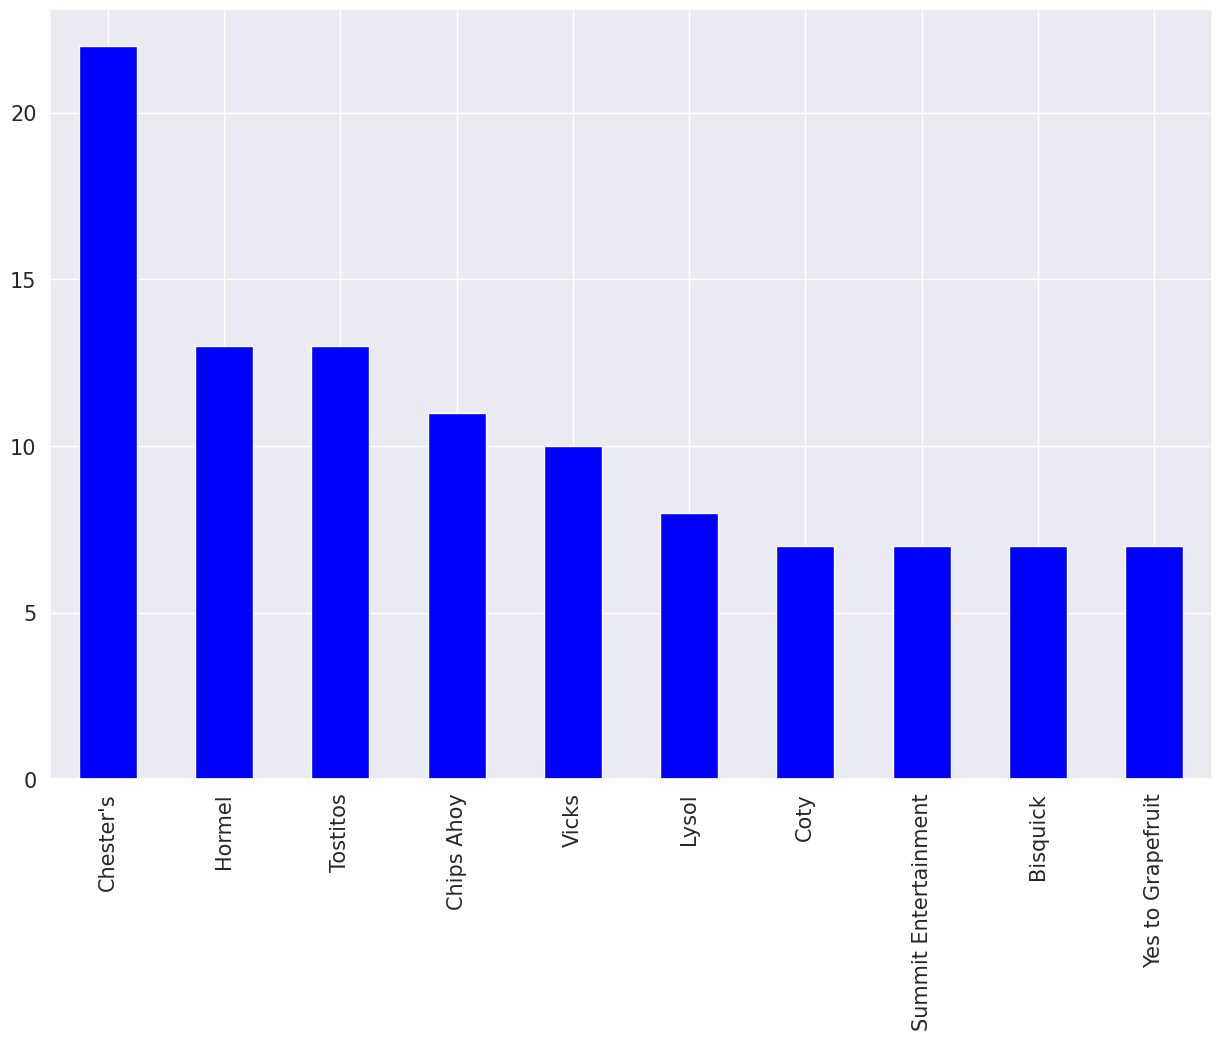

In [ ]:
#Checking top 10 most badly rated brands based on the negative review
from matplotlib import cm

result = df[(df['reviews_didPurchase'] == True) & (df.user_sentiment=="Negative")]
result['brand'].value_counts()[0:10].plot(kind = 'bar', figsize=[15,10], fontsize=15,color='Blue')

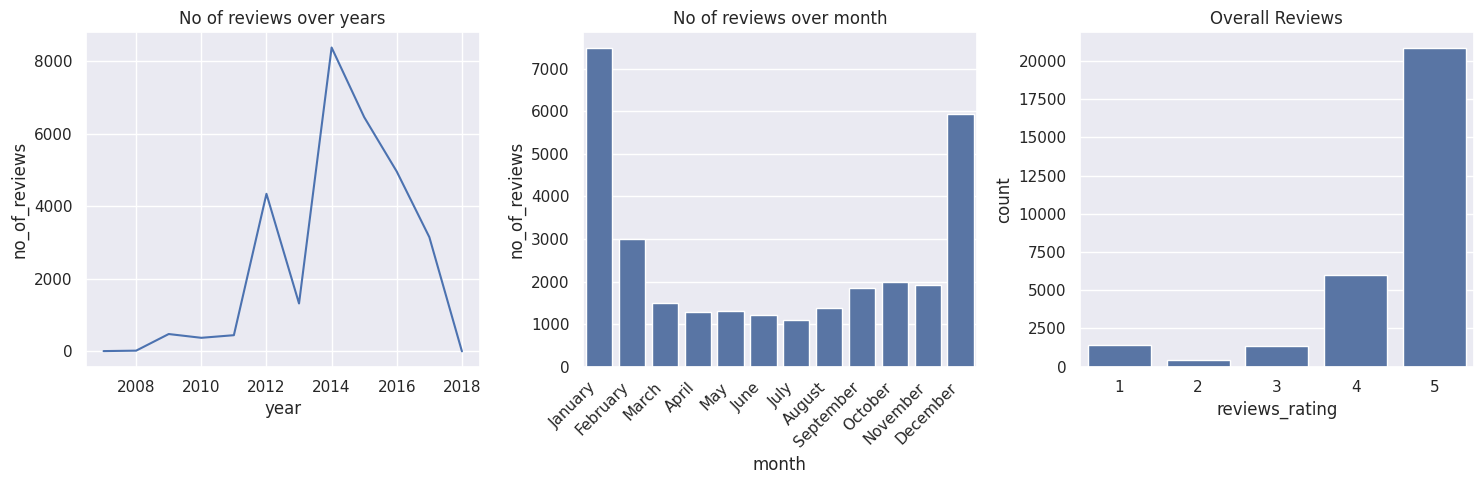

In [ ]:
#--- split the date into seperate columns of date month and year
#--- extract date from the reviews_date column
df['reviews_onlydate'] = df['reviews_date'].str[:10]
df['reviews_onlydate'].head()
#--- split the date into seperate columns of date month and year
#--- set the datatype to the above extracted date column
df['reviews_onlydate'] = pd.to_datetime(df['reviews_onlydate'], errors='coerce').dt.date
df['reviews_onlydate'].fillna(df['reviews_onlydate'].value_counts().idxmax(),inplace=True)
df['reviews_onlydate'] = pd.to_datetime(df.reviews_onlydate, format='%Y-%m-%d')
df['reviews_onlydate'].head()
#--- split the date into seperate columns of date month and year
df['month'] = df['reviews_onlydate'].dt.month
df['year'] = df['reviews_onlydate'].dt.year
f, axes = plt.subplots(1,3, figsize=(15,5))
#--- Yearly Reviews
yearly = df.groupby(['year'])['reviews_username'].count().reset_index()
yearly = yearly.rename(columns={'reviews_username':'no_of_reviews'})
yearChart = sns.lineplot(x='year',y='no_of_reviews',data=yearly, ax = axes[0])
yearChart.set_title('No of reviews over years')

#--- Monthly Reviews
monthly = df.groupby(['month'])['reviews_username'].count().reset_index()
monthly['month'] = monthly['month'].apply(lambda x : calendar.month_name[x])
monthly = monthly.rename(columns={'reviews_username':'no_of_reviews'})
monthChart = sns.barplot(x='month',y='no_of_reviews',data=monthly, ax = axes[1])
monthChart.set_title('No of reviews over month')
monthChart.set_xticklabels(monthChart.get_xticklabels(), rotation = 45, horizontalalignment = 'right')

#-- Getting overall ratings for all products
sns.countplot(x = 'reviews_rating', data = df, ax = axes[2] ).set_title('Overall Reviews')

f.tight_layout()

Platform started receiving reviews starting year 2011 and it gradually peaked in 2014 with a steep decline following years, something for the platform to analyze the reason behind decline in providing feedback.

Dec - Jan seems to the shopping season with maximum reviews recorded over years.

Platform products few have rating 1 , while most of the products hosted on the platform have good rating of 5 stars. italicized text

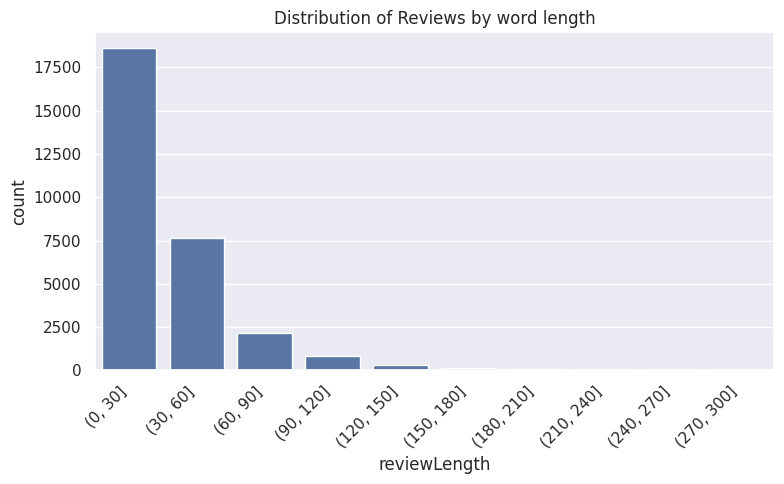

In [ ]:
#f, axes = plt.subplots(1,1, figsize=(12,8))
#---- Distribution of word reviews by length
f = plt.figure(figsize=(8,5))
df_reviews = df[['id','reviews_username','reviews_text','reviews_title','reviews_rating']]
df_reviews['reviewLength'] = df_reviews['reviews_text'].apply(lambda x: len(x.split()))

reviews_word_length = df_reviews.groupby(pd.cut(df_reviews.reviewLength, np.arange(0,330,30))).count()
reviews_word_length = reviews_word_length.rename(columns={'reviewLength':'count'})
reviews_word_length = reviews_word_length.reset_index()

reviewLengthChart = sns.barplot(x='reviewLength',y='count',data=reviews_word_length)
reviewLengthChart.set_title('Distribution of Reviews by word length')
reviewLengthChart.set_xticklabels(reviewLengthChart.get_xticklabels(), rotation = 45, horizontalalignment = 'right')

f.tight_layout()

*Review length distribution indicates that reviews are of the form with short description.*

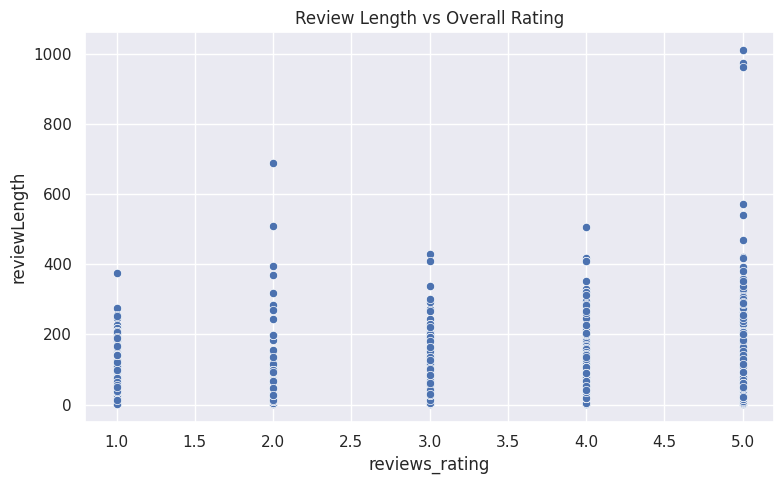

In [ ]:
#f, axes = plt.subplots(1,2, figsize=(12,8))
f = plt.figure(figsize=(8,5))

#--- Distribution of length of reviews vs overall rating
reviewLength_vs_Rating = df_reviews[['id','reviewLength','reviews_rating']]
reviewLength_vs_Rating = sns.scatterplot(x='reviews_rating', y='reviewLength', data=reviewLength_vs_Rating)
reviewLength_vs_Rating.set_title('Review Length vs Overall Rating')

f.tight_layout()

Review length variable has a correlation to the rating

## Data Preparation

In [ ]:
df.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_username', 'user_sentiment',
       'reviews_onlydate', 'month', 'year'],
      dtype='object')

In [ ]:
df.drop(['reviews_doRecommend','reviews_didPurchase'],axis=1,inplace=True)

In [ ]:
df.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_username',
       'user_sentiment', 'reviews_onlydate', 'month', 'year'],
      dtype='object')

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
#duplicates
duplicates = df[df.duplicated(subset={"reviews_username","id"})]
duplicates.reviews_username.value_counts()

byamazon customer    39
mike                 24
chris                19
tony                  7
movielover            6
                     ..
kayet19               1
spidysgirl            1
gissela               1
dkane514              1
filo123               1
Name: reviews_username, Length: 2116, dtype: int64

In [ ]:
# List Duplicate Review by top duplicate review customer
df[df['reviews_username'] == 'byamazon customer']

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_onlydate,month,year
16778,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2016-02-03T00:00:00.000Z,1,A waste of my money I don't know what kind of ...,Dyed Rice,byamazon customer,Positive,2016-02-03,2,2016
16799,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2017-01-07T00:00:00.000Z,4,"Good but if you like it, get it in quantity",Yum,byamazon customer,Positive,2017-01-07,1,2017
16807,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2015-08-19T00:00:00.000Z,4,RICE LOOKS GOOD.,RICE IS FINE,byamazon customer,Positive,2015-08-19,8,2015
16812,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2015-04-08T00:00:00.000Z,4,I love the zip lock seal on these bags (unique...,I love the zip lock seal on these bags (unique...,byamazon customer,Positive,2015-04-08,4,2015
16824,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2011-07-20T00:00:00.000Z,4,Lundberg Jubilee is a blend of sweet brown ric...,Beautiful and High-Quality Rice But Too Much S...,byamazon customer,Positive,2011-07-20,7,2011
16841,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2017-06-05T00:00:00.000Z,5,This takes much longer to cook but the taste i...,Happy,byamazon customer,Positive,2017-06-05,6,2017
16850,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2017-04-20T00:00:00.000Z,5,Great rice in a small package...I'll be buying...,Recommended,byamazon customer,Positive,2017-04-20,4,2017
16904,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2016-07-03T00:00:00.000Z,5,Very tasty! Very earthy rice great for breakfa...,Lindberg is just the best!,byamazon customer,Positive,2016-07-03,7,2016
16920,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2016-06-23T00:00:00.000Z,5,It was great. Very convenient in the 1 lb bags.,Five Stars,byamazon customer,Positive,2016-06-23,6,2016
16929,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2016-02-20T00:00:00.000Z,5,Good rice.,Five Stars,byamazon customer,Positive,2016-02-20,2,2016


Customer byamazon customer has more number of duplicate reviews

In [ ]:
#--average ratings
df['avg_ratings'] = df.groupby(['id','reviews_username'])['reviews_rating'].transform('mean')
df['avg_ratings']=df['avg_ratings'].round(2)
df[['id','reviews_username','reviews_rating','avg_ratings']]

,id,reviews_username,reviews_rating,avg_ratings
0,AV13O1A8GV-KLJ3akUyj,joshua,5,5.0
1,AV14LG0R-jtxr-f38QfS,dorothy w,5,5.0
2,AV14LG0R-jtxr-f38QfS,dorothy w,5,5.0
3,AV16khLE-jtxr-f38VFn,rebecca,1,1.0
4,AV16khLE-jtxr-f38VFn,walker557,1,1.0
...,...,...,...,...
29995,AVpfW8y_LJeJML437ySW,laurasnchz,5,5.0
29996,AVpfW8y_LJeJML437ySW,scarlepadilla,5,5.0
29997,AVpfW8y_LJeJML437ySW,liviasuexo,5,5.0
29998,AVpfW8y_LJeJML437ySW,ktreed95,5,5.0


In [ ]:
#Deleting all the duplicates having the same product id and username.
dfFinal =  df.drop_duplicates(subset={"reviews_username","id"},keep="first")

In [ ]:
size_diff = dfFinal['id'].size/df['id'].size
print("%.1f %% reduction in data after deleting duplicates"%((1-size_diff)*100))
print("Size of data",dfFinal['id'].size," rows ")

#---- Data is cleaned and no Duplicates are there

8.0 % reduction in data after deleting duplicates
Size of data 27605  rows 


In [ ]:
#Verify Duplicate Removal

dfFinal[dfFinal['reviews_username'] == 'byamazon customer']

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_onlydate,month,year,avg_ratings
16778,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2016-02-03T00:00:00.000Z,1,A waste of my money I don't know what kind of ...,Dyed Rice,byamazon customer,Positive,2016-02-03,2,2016,4.58
26450,AVpfPPkEilAPnD_xX3cP,Aveeno,"Personal Care,Sun Care,Featured Brands,Health ...",Aveeno Baby,Aveeno Baby Continuous Protection Lotion Sunsc...,2017-07-05T00:00:00.000Z,1,"The first time I used in my infant, he rubbed ...",Not Tear Free Not Useful,byamazon customer,Positive,2017-07-05,7,2017,3.41


In [ ]:
#concatenate user_text and user_title
# Filling missing values in Reviews title with blank space
dfFinal['reviews_title'] = dfFinal['reviews_title'].fillna('')
dfFinal['user_reviews'] = dfFinal[['reviews_title', 'reviews_text']].agg('. '.join, axis=1).str.lstrip('. ')
dfFinal[['reviews_title','reviews_text','user_reviews']]

,reviews_title,reviews_text,user_reviews
0,Just Awesome,i love this album. it's very good. more to the...,Just Awesome. i love this album. it's very goo...
1,Good,Good flavor. This review was collected as part...,Good. Good flavor. This review was collected a...
3,Disappointed,I read through the reviews on here before look...,Disappointed. I read through the reviews on he...
4,Irritation,My husband bought this gel for us. The gel cau...,Irritation. My husband bought this gel for us....
5,Not worth it,My boyfriend and I bought this to spice things...,Not worth it. My boyfriend and I bought this t...
...,...,...,...
29995,Softness!!,I got this conditioner with Influenster to try...,Softness!!. I got this conditioner with Influe...
29996,I love it,"I love it , I received this for review purpose...","I love it. I love it , I received this for rev..."
29997,Hair is so smooth after use,First of all I love the smell of this product....,Hair is so smooth after use. First of all I lo...
29998,Perfect for my oily hair!,I received this through Influenster and will n...,Perfect for my oily hair!. I received this thr...


In [ ]:
#--- HTML Tag Removal
import re #Regex (Regular Expr Operations)
#string = r"sdfsdfd" :- r is for raw string as Regex often uses \ backslashes(\w), so they are often raw strings(r’\d’)
########Function to remove html tags from data
def striphtml(data):
    p = re.compile('<.*?>')#Find this kind of pattern
    return p.sub('',data) #Substitute nothing at the place of strings which matched the patterns

In [ ]:
#--- Punctuation removal
########Function to remove All the punctuations from the text
def strippunc(data):
    p = re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]')
    return p.sub('',data)

In [ ]:
#--- StopWords
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop = stopwords.words('english') #All the stopwords in English language
from nltk.stem import SnowballStemmer

In [ ]:
snow = SnowballStemmer('english') #initialising the snowball stemmer

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [ ]:
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(snow.stem(word)) # stem the word if no lemma is obtaines
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [ ]:
#pre-processing output for one Review
def preprocessText(text, stem=False):


  text=text.lower() #--- transform to lower case
  text = striphtml(text) #--- remove HTML Tags
  text = strippunc(text) #--- remove Punctuation
  return lemmatize_sentence(text)

In [ ]:
import nltk
nltk.download('omw-1.4')

df_main = dfFinal.copy(deep = True)
df_main['Review'] = df_main['user_reviews'].map(preprocessText)
df_main.head()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_onlydate,month,year,avg_ratings,user_reviews,Review
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,2012-11-30,11,2012,5.0,Just Awesome. i love this album. it's very goo...,just awesome i love this album it very good mo...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,2017-07-09,7,2017,5.0,Good. Good flavor. This review was collected a...,good good flavor this review be collect as par...
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,2016-01-06,1,2016,1.0,Disappointed. I read through the reviews on he...,disappointed i read through the review on here...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,2016-12-21,12,2016,1.0,Irritation. My husband bought this gel for us....,irritation my husband buy this gel for us the ...
5,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-20T00:00:00.000Z,1,My boyfriend and I bought this to spice things...,Not worth it,samantha,Negative,2016-04-20,4,2016,1.0,Not worth it. My boyfriend and I bought this t...,not worth it my boyfriend and i buy this to sp...


Find the top 40 words by frequency among all the reviews after processing the text

(-0.5, 399.5, 199.5, -0.5)

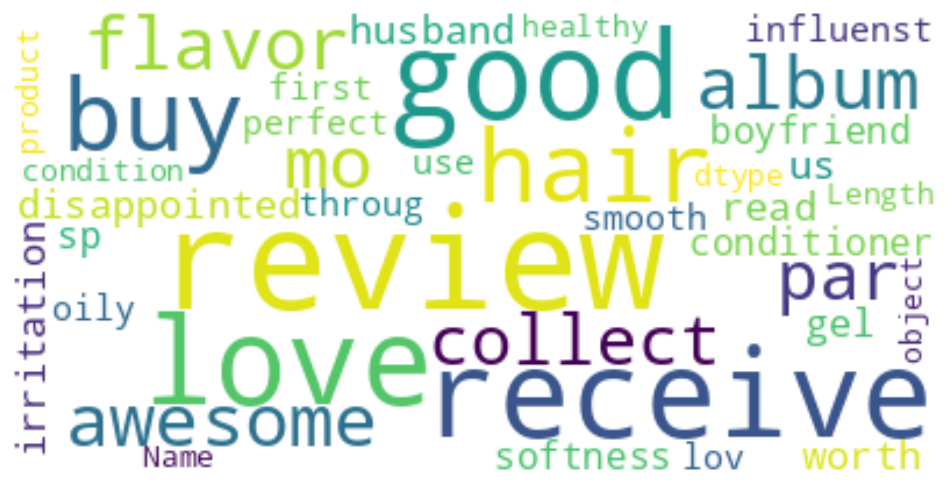

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=40,
                      background_color="white", random_state=100,
                      stopwords=stopwords).generate(str(df_main['Review']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

In [ ]:
#Write your code here to find the top 30 unigram frequency among the Reviews
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

def get_top_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]

In [ ]:
#Print the top 30 words in the unigram frequency
top_30words = get_top_ngrams(df_main['Review'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,great,13976
1,use,12230
2,love,12003
3,product,11142
4,movie,10460
5,review,8368
6,wipe,7835
7,collect,7789
8,promotion,7766
9,clean,7429


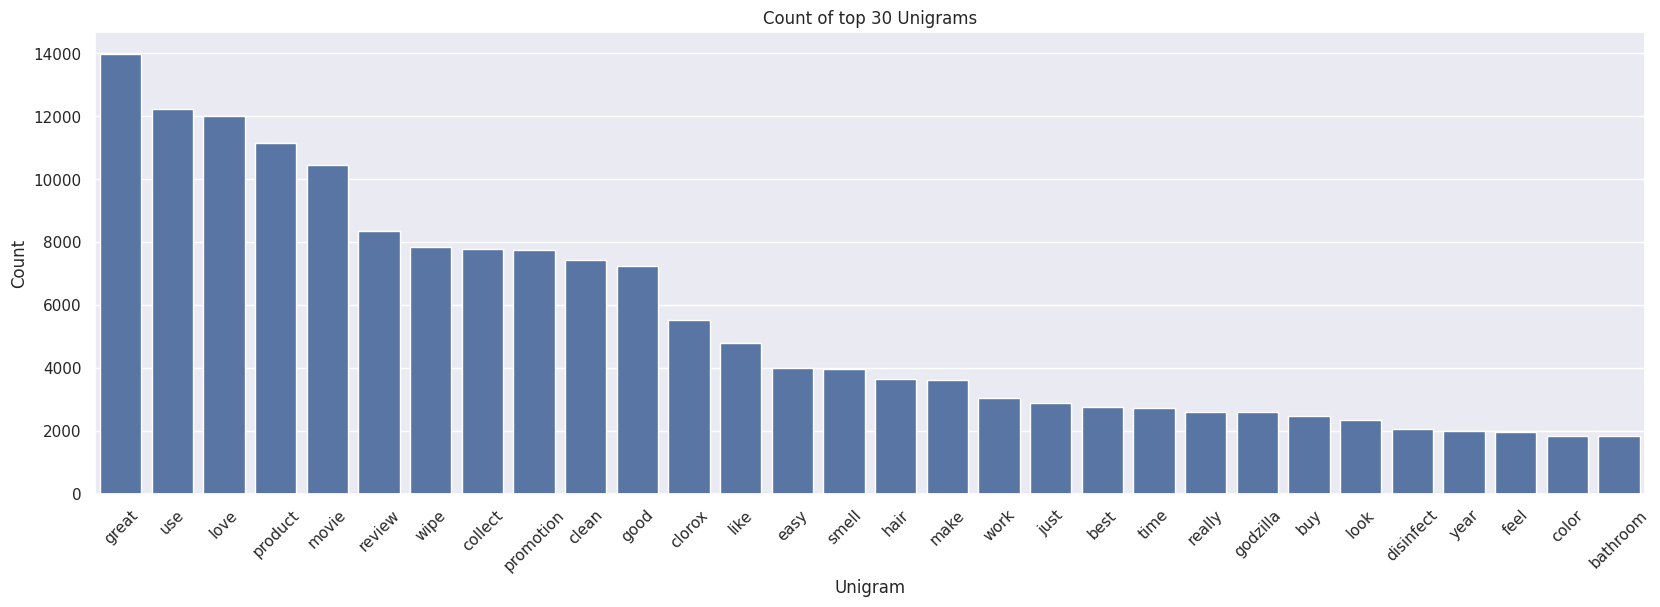

In [ ]:
# Plotting top 30 Unigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [ ]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,great,13976
1,use,12230
2,love,12003
3,product,11142
4,movie,10460
5,review,8368
6,wipe,7835
7,collect,7789
8,promotion,7766
9,clean,7429


In [ ]:
#Write your code here to find the top 30 bigram frequency among the reviews
top_30words = get_top_ngrams(df_main['Review'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30words, columns=['bigram', 'count'])
df_bigram

,bigram,count
0,review collect,7762
1,collect promotion,7762
2,clorox wipe,2627
3,great product,1842
4,great movie,1672
5,easy use,1462
6,love clorox,1133
7,love product,1069
8,use clorox,997
9,good movie,990


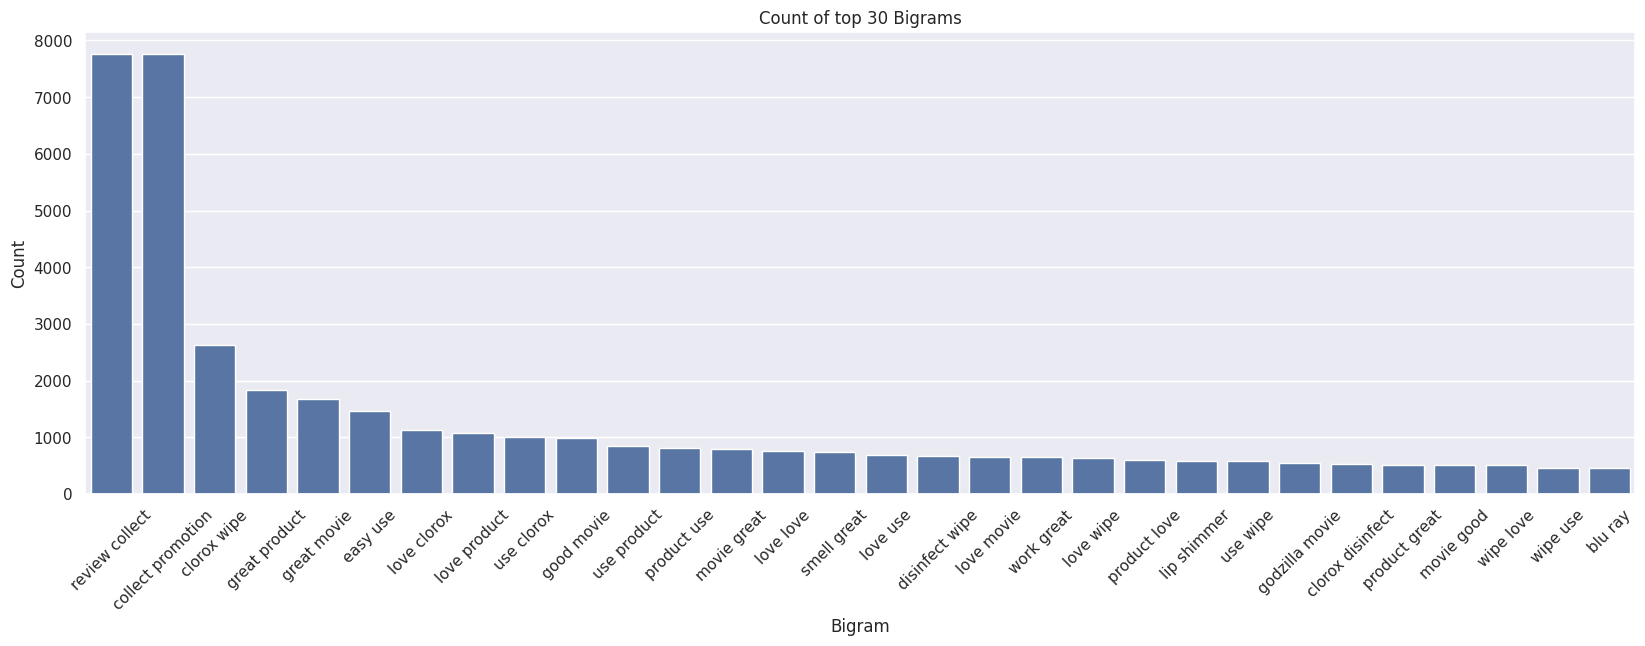

In [ ]:
# Plotting top 30 Bigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_bigram['bigram'], y=df_bigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Count of top 30 Bigrams")
plt.show()

In [ ]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,review collect,7762
1,collect promotion,7762
2,clorox wipe,2627
3,great product,1842
4,great movie,1672
5,easy use,1462
6,love clorox,1133
7,love product,1069
8,use clorox,997
9,good movie,990


## Sentiment Analysis

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [ ]:
#droping unnecessary columns
df_main=df_main[['Review','reviews_rating','user_sentiment']]
data=df_main
df_main

,Review,reviews_rating,user_sentiment
0,just awesome i love this album it very good mo...,5,Positive
1,good good flavor this review be collect as par...,5,Positive
3,disappointed i read through the review on here...,1,Negative
4,irritation my husband buy this gel for us the ...,1,Negative
5,not worth it my boyfriend and i buy this to sp...,1,Negative
...,...,...,...
29995,softness i get this conditioner with influenst...,5,Positive
29996,i love it i love it i receive this for review ...,5,Positive
29997,hair be so smooth after use first of all i lov...,5,Positive
29998,perfect for my oily hair i receive this throug...,5,Positive


In [ ]:
# saving data for future purpose
import pickle as pickle
pickle.dump(data, open("data.pkl","wb"))

In [ ]:
import pickle
from pathlib import Path
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf_vectorizer.fit(data['Review'])
X = tfidf_vectorizer.transform(data['Review'])
y = data['user_sentiment']

# Saving the vocabulary used in tfidf vectorizer as features
pickle.dump(tfidf_vectorizer.vocabulary_, open("features.pkl","wb"))

# Split train test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [ ]:
### Class Imbalance check and method to handle it
data.groupby(['user_sentiment']).count()

,Review,reviews_rating
user_sentiment,,
Negative,3058,3058
Positive,24547,24547


In [ ]:
from collections import Counter
from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
counter = Counter(y_train)
print("Before", counter)

#oversampling using SMOTE
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print("After", counter)

Before Counter({'Positive': 18449, 'Negative': 2254})
After Counter({'Positive': 18449, 'Negative': 18449})


In [147]:
#### Creating a utility method for creating confusion matrix and displaying scores

from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
def display_score(classifier):
    # Make predictions on the test data
    y_pred = classifier.predict(X_test)
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, values_format='.4g')


    # Calculate performance scores
    accuracy = accuracy_score(y_test, y_pred)
    print(classifier)
    print('\n')
    print('Accuracy is ', accuracy_score(y_test, classifier.predict(X_test)))
    print('Sensitivity is {}'.format(cm[1][1]/sum(cm[1])))
    print('Specificity is {}'.format(cm[0][0]/sum(cm[0])))

# Model building

## Logistic regression

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import pickle

In [ ]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:

    lr = LogisticRegression(C=c)
    lr.fit(X_train_sm, y_train_sm)
    cm = confusion_matrix(y_test, lr.predict(X_test))
    print('Sensitivity for C = {0} is {1}'.format(c, cm[1][1]/sum(cm[1])))
    print('Specificity for C = {0} is {1}'.format(c, cm[0][0]/sum(cm[0])))

Sensitivity for C = 0.01 is 0.8184650705149229
Specificity for C = 0.01 is 0.7599502487562189
Sensitivity for C = 0.05 is 0.8384716300426369
Specificity for C = 0.05 is 0.7711442786069652
Sensitivity for C = 0.25 is 0.8807805837979665
Specificity for C = 0.25 is 0.7425373134328358
Sensitivity for C = 0.5 is 0.9017710724827812
Specificity for C = 0.5 is 0.7189054726368159
Sensitivity for C = 1 is 0.9204657264676943
Specificity for C = 1 is 0.6878109452736318


In [108]:
final_lr = LogisticRegression(C=0.05)
final_lr.fit(X_train_sm, y_train_sm)

LogisticRegression(C=0.05)

In [112]:
# prompt: plot final_lr using display confusion matrix

print(cm)

[[ 553  251]
 [ 485 5613]]


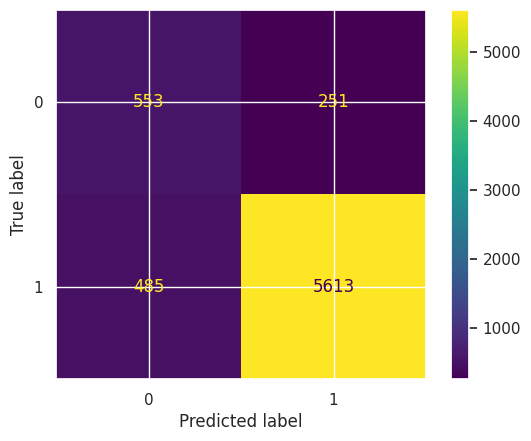

In [113]:
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_disp.plot()

LogisticRegression(C=0.05)


Accuracy is  0.8306288032454361
Sensitivity is 0.8451951459494916
Specificity is 0.3644278606965174


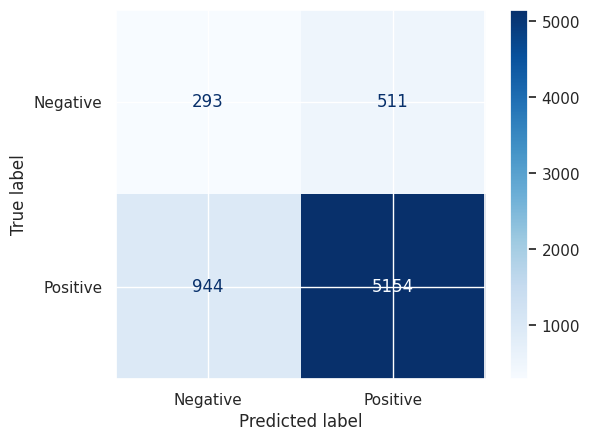

In [152]:
display_score(final_lr)

In [114]:
()# saving the model
pickle.dump(final_lr, open('final_lr.pkl', 'wb'))
pickle.dump(tfidf_vectorizer, open("tfidf.pkl", "wb"))

In [115]:
tfs=pd.read_pickle('tfidf.pkl')
mdl=pd.read_pickle('final_lr.pkl')

## Random Forest Classifier

In [125]:
#Fitting a Random Forest classifier without any hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier()

RandomForestClassifier()


Accuracy is  0.8830773688785859
Sensitivity is 0.8451951459494916
Specificity is 0.3644278606965174


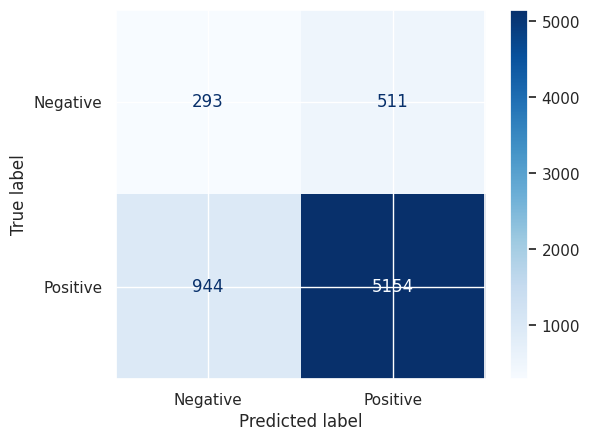

In [150]:
display_score(rf)


####Hyperparameter Tuning

In [119]:
# Create the parameter grid based on the results of random search
param_grid = {
    'max_depth': [15, 20],
    'min_samples_leaf': [100,200],
    'min_samples_split': [200,400],
    'n_estimators': [100, 300]
}

# Create a based model
final_rf = RandomForestClassifier()

# Instantiate the grid search model
rf_tuned = GridSearchCV(estimator = final_rf, param_grid = param_grid, scoring='roc_auc', cv = 3, n_jobs = -1,verbose = 1)
rf_tuned.fit(X_train_sm, y_train_sm)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15, 20], 'min_samples_leaf': [100, 200],
                         'min_samples_split': [200, 400],
                         'n_estimators': [100, 300]},
             scoring='roc_auc', verbose=1)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15, 20], 'min_samples_leaf': [100, 200],
                         'min_samples_split': [200, 400],
                         'n_estimators': [100, 300]},
             scoring='roc_auc', verbose=1)


Accuracy is  0.7891915386844393
Sensitivity is 0.8451951459494916
Specificity is 0.3644278606965174


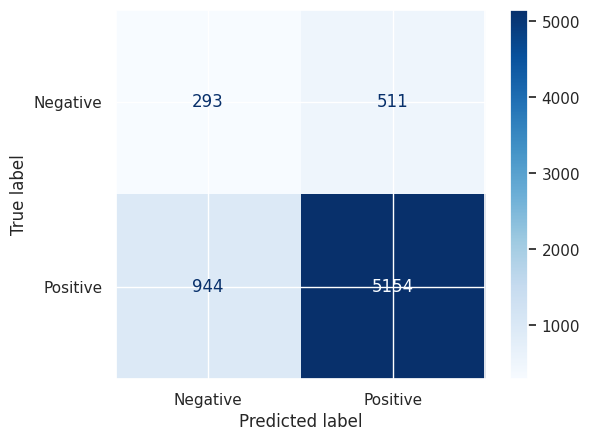

In [149]:
display_score(rf_tuned)

## Naive Bayes

In [137]:
# Fitting Naive Bayes Model
nb=MultinomialNB()
nb.fit(X_train_sm, y_train_sm)

MultinomialNB()

MultinomialNB()


Accuracy is  0.8594610257896262
Sensitivity is 0.8451951459494916
Specificity is 0.3644278606965174


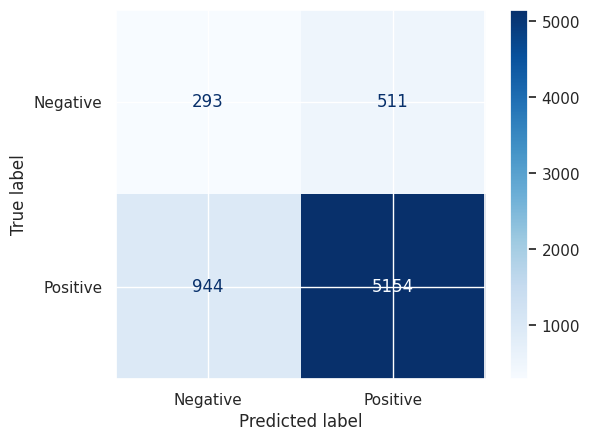

In [148]:
display_score(nb)

In [156]:
results = {('LogisticRegression'):[0.83, 0.85, 0.74], ('NaiveBayes'):[0.86, 0.89, 60],
 ('RandomForest'):[0.91, 0.99, 0.23], ('RandomForest Tuned'):[0.81, 0.86, 0.36]}
pd.DataFrame(results, index=['Accuracy', 'Sensitivity', 'Specificity'])

,LogisticRegression,NaiveBayes,RandomForest,RandomForest Tuned
Accuracy,0.83,0.86,0.91,0.81
Sensitivity,0.85,0.89,0.99,0.86
Specificity,0.74,60.00,0.23,0.36


In [157]:
import pickle
# Save the best trained model as a pickle string.
saved_model = pickle.dump(final_lr, open('logistic_regression.pkl', 'wb'))
saved_model_2 = pickle.dump(final_lr, open('rf_tuned.pkl', 'wb'))

Recommendation System


1.   User based recommendation
2.   User based prediction & evaluation
3.   Item based recommendation
4.   Item based prediction & evaluation




In [158]:
# Importing Libraries
from sklearn.metrics.pairwise import pairwise_distances

In [159]:
# Read the dataset
ratings = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sample30.csv", sep=',')
ratings.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive


In [160]:
ratings=ratings[['id', 'reviews_rating', 'reviews_username']]

In [161]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                30000 non-null  object
 1   reviews_rating    30000 non-null  int64 
 2   reviews_username  29937 non-null  object
dtypes: int64(1), object(2)
memory usage: 703.2+ KB


In [162]:
#Remove rows where username has null values
ratings = ratings[~ratings.reviews_username.isna()]
ratings.columns=['productId', 'rating', 'user']
ratings.head()

,productId,rating,user
0,AV13O1A8GV-KLJ3akUyj,5,joshua
1,AV14LG0R-jtxr-f38QfS,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,5,dorothy w
3,AV16khLE-jtxr-f38VFn,1,rebecca
4,AV16khLE-jtxr-f38VFn,1,walker557


In [163]:
# Test and Train split of the dataset.
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.30, random_state=12)
print(train.shape)
print(test.shape)

(20955, 3)
(8982, 3)


In [164]:
# Pivot the train ratings' dataset into matrix format in which columns are products and the rows are user IDs.
df_pivot = train.pivot_table(
    index='user',
    columns='productId',
    values='rating'
).fillna(0)

df_pivot.head(3)

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

dummy_train.head()

,productId,rating,user
27729,AVpfRTh1ilAPnD_xYic2,5,stevieboy23
17120,AVpf9pzn1cnluZ0-uNTM,5,byo.kelly
22028,AVpfnRuSilAPnD_xfB8l,3,linda h
16308,AVpf63aJLJeJML43F__Q,5,cocoacrazy
19457,AVpfJP1C1cnluZ0-e3Xy,5,vanessavast


In [166]:
# The products not rated by user is marked as 1 for prediction.
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>=1 else 1)

In [167]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='user',
    columns='productId',
    values='rating'
).fillna(1)


dummy_train.head()

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [168]:
df_pivot.index.nunique()

18188

Cosine Similarity

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case]

Adjusted Cosine

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different products.

In [169]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.        ... 0.        0.9486833 0.       ]
 [0.        0.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.        0.9486833 0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]


In [170]:
user_correlation.shape

(18188, 18188)

## Adjusted Cosine

In [171]:
# Create a user-product matrix.
df_pivot = train.pivot_table(
    index='user',
    columns='productId',
    values='rating'
)

In [172]:
df_pivot.head()

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

df_subtracted.head()

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [174]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [175]:
user_correlation.shape

(18188, 18188)

Predicition User

In [176]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [177]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.93649167,
        0.20412415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [178]:
user_predicted_ratings.shape

(18188, 251)

In [179]:
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.93649167,
        0.20412415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [180]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
00sab00,0.0,0.0,0.0,0.0,0.0,0.749669,0.0,0.944911,0.0,0.0,...,0.0,0.0,0.0,1.597933,0.0,0.0,0.0,0.0,1.936492,0.204124
01impala,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02dakota,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02deuce,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [181]:
user_final_rating

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
00sab00,0.0,0.0,0.0,0.0,0.0,0.749669,0.0,0.944911,0.0,0.0,...,0.0,0.0,0.0,1.597933,0.0,0.0,0.0,0.0,1.936492,0.204124
01impala,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02dakota,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02deuce,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
zxcsdfd,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
zyiah4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [182]:
# Take the user ID as input.
user_input='zuttle'
print(user_input)

zuttle


In [183]:
user_final_rating.head(10)

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
00sab00,0.0,0.000000,0.000000,0.0,0.0,0.749669,0.0,0.944911,0.0,0.0,...,0.0,0.0,0.0,1.597933,0.0,0.0,0.0,0.0,1.936492,0.204124
01impala,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02dakota,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02deuce,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
08dallas,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
1.11E+24,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
10ten,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
11111111aaaaaaaaaaaaaaaaa,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [184]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

productId
AV14LG0R-jtxr-f38QfS    0.0
AVpfPPkEilAPnD_xX3cP    0.0
AVpfN6Z71cnluZ0-gZmO    0.0
AVpfNVsj1cnluZ0-gNQN    0.0
AVpfNWbPilAPnD_xXPR7    0.0
AVpfNc9cLJeJML434tza    0.0
AVpfNfEMLJeJML434uf-    0.0
AVpfNglu1cnluZ0-gQ7x    0.0
AVpfO5u71cnluZ0-guiN    0.0
AVpfOIrkilAPnD_xXgDG    0.0
AVpfOfIqLJeJML435D06    0.0
AVpfOmKwLJeJML435GM7    0.0
AVpfOrD0ilAPnD_xXrRj    0.0
AVpfP-rELJeJML435jEN    0.0
AVpfPKzxLJeJML435SYL    0.0
AVpfPaoqLJeJML435Xk9    0.0
AVpfSvmGilAPnD_xY_gE    0.0
AVpfPjqKLJeJML435aZR    0.0
AVpfPkrkilAPnD_xX-L9    0.0
AVpfPnrU1cnluZ0-g9rL    0.0
Name: zuttle, dtype: float64

## Evaluation - User User

Item Based Similarity Taking the transpose of the rating matrix to normalize the rating around the mean for different products ID. In the user based similarity, we had taken mean for each user instead of each products.

In [193]:
df_pivot = train.pivot_table(
    index='user',
    columns='productId',
    values='rating'
).T

df_pivot.head()

user,00dog3,00sab00,01impala,02dakota,02deuce,08dallas,1.11E+24,10ten,11111111aaaaaaaaaaaaaaaaa,1234,...,zsarah,zsazsa,zt313,zubb,zulaa118,zuttle,zxcsdfd,zyiah4,zzdiane,zzz1127
productId,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the products rating for each products for using the Adujsted Cosine

In [194]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

df_subtracted.head()

user,00dog3,00sab00,01impala,02dakota,02deuce,08dallas,1.11E+24,10ten,11111111aaaaaaaaaaaaaaaaa,1234,...,zsarah,zsazsa,zt313,zubb,zulaa118,zuttle,zxcsdfd,zyiah4,zzdiane,zzz1127
productId,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finding cosine similarities

In [195]:
from sklearn.metrics.pairwise import pairwise_distances

# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)
print(item_correlation.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(251, 251)


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [196]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

##**Prediction - Item Item**


In [197]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00666715, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00693369],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00554695]])

In [198]:
item_predicted_ratings.shape

(18188, 251)

In [191]:
dummy_train.shape

(18188, 251)

Filtering the rating only for the products not rated by the user for recommendation

In [199]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.006364,0.0,0.000000,...,0.0,0.014313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.006667,0.0,0.0,0.0,0.0,0.004563,0.000000,0.0,0.000896,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.011112,0.0,0.0,0.0,0.0,0.007606,0.000000,0.0,0.001493,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.008890,0.0,0.0,0.0,0.0,0.006084,0.000000,0.0,0.001195,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finding the top 20 recommendation for the user

In [200]:
# Take the user ID as input

user_input='02deuce'
print(user_input)

02deuce


In [201]:
# Recommending the Top 20 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

productId
AVpfRTh1ilAPnD_xYic2    0.044594
AVpfOmKwLJeJML435GM7    0.044586
AVpf0thK1cnluZ0-r8vR    0.035166
AVpf4WWN1cnluZ0-s7Wj    0.027882
AVpfQtEm1cnluZ0-hUpe    0.024353
AVpfR5m0LJeJML436K3W    0.022109
AVpe8q4T1cnluZ0-afct    0.018664
AVpfBrUZilAPnD_xTUly    0.017463
AVpe8dHWLJeJML43y4uG    0.016326
AVpe4hlXLJeJML43xbrB    0.015766
AVpfN6Z71cnluZ0-gZmO    0.014743
AVpf7LysilAPnD_xkm9G    0.014598
AVpfOIrkilAPnD_xXgDG    0.013578
AVpe5c23LJeJML43xybi    0.012478
AVpfAkX91cnluZ0-b4d8    0.011157
AVpfr5cb1cnluZ0-pZFp    0.010991
AVpfKOYiilAPnD_xWOFw    0.009090
AV16khLE-jtxr-f38VFn    0.008890
AVpe6FfKilAPnD_xQmHi    0.007972
AVpe_N91LJeJML43z4jD    0.006754
Name: 02deuce, dtype: float64

In [202]:
# saving the model
pickle.dump(user_final_rating.astype('float32'), open('user_final_rating.pkl', 'wb'))

## Evaluation - Item Item

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the products already rated by the user insead of predicting it for the products not rated by the user.

In [203]:
test.columns

Index(['productId', 'rating', 'user'], dtype='object')

In [204]:
common =  test[test.productId.isin(train.productId)]
common.shape

(8962, 3)

In [205]:
common.head(4)

,productId,rating,user
19513,AVpfJP1C1cnluZ0-e3Xy,5,kanderson927
12599,AVpf3VOfilAPnD_xjpun,5,arib
1587,AVpe31o71cnluZ0-YrSD,4,karv
15380,AVpf5FF71cnluZ0-tHAV,5,xxacw12xx


In [207]:
common_item_based_matrix = common.pivot_table(index='user', columns='productId', values='rating').T

In [208]:
common_item_based_matrix.shape

(199, 8383)

In [209]:
item_correlation_df = pd.DataFrame(item_correlation)

In [210]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [211]:
item_correlation_df['productId'] = df_subtracted.index
item_correlation_df.set_index('productId',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
productId,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [212]:
list_name = common.productId.tolist()

In [213]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [214]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [215]:
item_correlation_df_3.head()

,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
productId,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.037657,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.066184,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [216]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.07508529, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00693369, 0.00693369, 0.01091379, ..., 0.        , 0.00693369,
        0.00277348]])

In [217]:

common_item_predicted_ratings.shape

(199, 8383)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [218]:
dummy_test = common.copy()

dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='user', columns='productId', values='rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion

In [219]:
common_ = common.pivot_table(index='user', columns='productId', values='rating').T

In [220]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [221]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [222]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.550271694270667
